<a href="https://colab.research.google.com/github/Kyrylo-Bakumenko/NFL_Gamba_And_Power_Rankings/blob/main/Single_Method_of_NFL_Historical_Elo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
#@title Imports and Settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
from tqdm import tqdm
from numba import jit, njit
from numba import prange
from scipy.stats import invgauss
from concurrent.futures import ThreadPoolExecutor
%pylab inline

# mount google drive
from google.colab import drive
drive.mount('/content/drive/')

# season data: https://www.pro-football-reference.com/years/2019/games.htm
URL_BASE = 'https://www.pro-football-reference.com/years/'
URL_END = '/games.htm'

# quality of life
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Populating the interactive namespace from numpy and matplotlib
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
#@title Variables for notebook

START_YEAR = 1988 # first year in time frame
END_YEAR = 2020 # last year of time frame (non-inclusive)
SIM_COUNT = 200 # simulation count run for dynamic season prediction methods
SEASON_STARTED = False # use pickle?

#                              |
# hyperparameters to optimize \|/
MAX_GAIN = 32 # max elo awarded per win
SEASON_ADJ = 10 # max elo regressed from season placements
DELTA = 2 # factor by which early season games are more volatile
EPSILON = 1.2 # rate of decay for DELTA
mu = 20 # mu for wager function bet size normalization
edge_max = 1.5 # value of edge for maximum bet increase

# methedology: optimize for accuracy using elo metrics,
# optimize profit with wager metrics

In [3]:
#@title user made functions
# return probability left wins in accordance to elo system
@njit(nogil=True)
def win_prob(player_elo, opponent_elo):
  return 1/(1+10**((-player_elo+opponent_elo)/400))

@jit
def elo_change(player_elo, opponent_elo, result, MAX_GAIN, DELTA):
  player_win_prob = win_prob(player_elo, opponent_elo)
  return (player_elo + (MAX_GAIN*DELTA) * (result-player_win_prob))

# generates list of season names
@njit(nogil=True)
def get_season_names(start, end, step=1):
    seasons = ["Reference"]
    while start+step < end:
      start+=step
      seasons.append("'"+str(start)[-2:])
    seasons.append("'"+str(end)[-2:])
    return seasons

  ### Web scraping method

def scraped_season_list(START_YEAR, END_YEAR):
  seasons = []
  for year in range(START_YEAR, END_YEAR):
    try:
      df = pd.read_html(URL_BASE + str(year) + URL_END, header=0)[0]
      df.drop(columns=['Day', 'Week', 'Time', 'Unnamed: 5', 'Unnamed: 7', 'YdsW', 'TOW', 'YdsL', 'TOL'], inplace=True)
      df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
      df.dropna(inplace=True)
      df.set_index('Date', inplace=True)
      seasons.append(df)
    except:
      print(f'Failed at year: {year}')
      break
  return seasons

In [4]:
  #@title Abbreviate teams, Create and Label seasons
  # import team name and abbreviation data
  teams_abbr = pd.read_excel("/content/drive/My Drive/NFL_Analysis_Data/NFL_Season_Data.xlsx", sheet_name="TeamsABBR", header=0)
  teams_abbr=teams_abbr.set_index("Franchise")
  teams_abbr=teams_abbr.rename(columns={"Commonly Used Abbreviations": "Abbr"})

  # set aside list of abbreviations
  teams = teams_abbr["Abbr"].drop_duplicates().values

  # create name to abbreviation dictionary
  name_to_abbr = teams_abbr.to_dict()
  name_to_abbr = name_to_abbr["Abbr"]

  # creates a list of every season of nfl games from start year (inclusive) to end year (non-inclusive)
  seasons = scraped_season_list(START_YEAR, END_YEAR)

In [5]:
#@title User made functions

### Deprecated file method
def create_season_list_by_years(START_YEAR, END_YEAR):
  seasons = []
  for i in range(START_YEAR, END_YEAR):
    try:
      seasons.append(pd.read_excel("/content/NFL_Season_Data.xlsx", sheet_name=str(i), header=0, usecols="B:F", index_col=0))
    except:
      break
  return seasons
###

def list_rename_dropna(seasons):
  for cur_season in seasons:
    # rename because we will check for draws
    cur_season.rename(columns={"Winner/tie": "Left", "Loser/tie": "Right"}, inplace=True)
    # remove nan's (artifacts from website)
    cur_season.dropna(inplace=True)
    # bridge name changes by using consistent abbreviations
    cur_season["Left"]=cur_season["Left"].map(name_to_abbr).values
    cur_season["Right"]=cur_season["Right"].map(name_to_abbr).values
  return seasons

### set up predict method ###
# 256 games in regular season pre 2021
def predict_season_standings_static(Elo, cur_season):
  pred_table = pd.DataFrame(teams)
  pred_table["Wins"]=0
  pred_table.rename(columns={0: "Team"}, inplace=True)
  pred_table.set_index("Team", inplace=True)
  sim_table = pred_table
  for sim in range(SIM_COUNT):
    pred_table["Wins"]=0
    for i in range(256):
        # determine if left or right won, check scores
        #   0     1     2    3
        # Left	Right	Pts	Pts.1
        left = cur_season.iloc[i, 0]
        right = cur_season.iloc[i, 1]
        # win_prob is the probability the "left" player wins.
        # If the random number simulated is less than win_prob,
        # this even is considered true, otherwise "right" wins.
        rand = np.random.uniform()
        if rand < win_prob(Elo[left], Elo[right]):
          # left wins
          pred_table.loc[left, "Wins"] = pred_table.loc[left, "Wins"]+1

        elif rand > win_prob(Elo[left], Elo[right]):
          # right wins
          pred_table.loc[right, "Wins"] = pred_table.loc[right, "Wins"]+1
        else:
          # draw
          pred_table.loc[left, "Wins"] = pred_table.loc[left, "Wins"]+0.5
          pred_table.loc[right, "Wins"] = pred_table.loc[right, "Wins"]+0.5
    sim_table = sim_table + pred_table
  sim_table = sim_table/SIM_COUNT
  return sim_table.rename(columns={"Wins": "Stat_Wins"})


### considers the elo change of its own predicted outcomes ###
def predict_season_standings_dynamic(Elo, cur_season):
  pred_table = pd.DataFrame(teams)
  pred_table["Wins"]=0
  pred_table.rename(columns={0: "Team"}, inplace=True)
  pred_table.set_index("Team", inplace=True)
  sim_table = pred_table
  for sim in range(SIM_COUNT):
    pred_table["Wins"]=0
    for i in range(256):
      # determine if left or right won, check scores
      #   0     1     2    3
      # Left	Right	Pts	Pts.1
      left = cur_season.iloc[i, 0]
      right = cur_season.iloc[i, 1]
      # win_prob is the probability the "left" player wins.
      # If the random number simulated is less than win_prob,
      # this even is considered true, otherwise "right" wins.
      rand = np.random.uniform()
      if rand < win_prob(Elo[left], Elo[right]):
        # left wins
        pred_table.loc[left, "Wins"] = pred_table.loc[left, "Wins"]+1
        Elo.update({
            left: elo_change(Elo[left], Elo[right], 1, MAX_GAIN, DELTA_copy),
            right: elo_change(Elo[right], Elo[left], 0, MAX_GAIN, DELTA_copy)
        })

      elif rand > win_prob(Elo[left], Elo[right]):
        # right wins
        pred_table.loc[right, "Wins"] = pred_table.loc[right, "Wins"]+1
        Elo.update({
            left: elo_change(Elo[left], Elo[right], 0, MAX_GAIN, DELTA_copy),
            right: elo_change(Elo[right], Elo[left], 1, MAX_GAIN, DELTA_copy)
        })
      else:
        # draw
        pred_table.loc[left, "Wins"] = pred_table.loc[left, "Wins"]+0.5
        pred_table.loc[right, "Wins"] = pred_table.loc[right, "Wins"]+0.5
        Elo.update({
          left: elo_change(Elo[left], Elo[right], 0.5, MAX_GAIN, DELTA_copy),
          right: elo_change(Elo[right], Elo[left], 0.5, MAX_GAIN, DELTA_copy)
        })
    # print(pred_table.max(axis = 0))
    sim_table = sim_table + pred_table
  sim_table = sim_table/SIM_COUNT
  return sim_table.rename(columns={"Wins": "Dyn_Wins"})

In [6]:
  #@title finish season data processing

  # does some reformating and na dropping
  seasons = list_rename_dropna(seasons)

  # if no elo rankings have been done, make 1000
  if not SEASON_STARTED:
    Elo = dict(zip(teams, np.full(shape=teams.shape[0], fill_value=1000)))

In [7]:
#@title betting data

#!# Import and Manage target season odds and games
# import moneyline betting data for 2020-21 season
game_bets = pd.read_excel("/content/drive/My Drive/NFL_Analysis_Data/NFL_Odds_2020-21.xlsx", sheet_name="Sheet1", header=0, usecols="D, I, L")#, index_col=0)

# convert ML into effective odds bookies are estimating
game_bets["Bookies Odds"] = 0

for row in range(game_bets["ML"].size):
  ML = game_bets["ML"][row]
  if ML > 0: # positive - udnerdog
    game_bets.iloc[row, 3] = 100/(ML+100)
  else: # negative - favorite
    game_bets.iloc[row, 3] = abs(ML)/(abs(ML)+100)

# prepare target gamble season games
tt_season = scraped_season_list(START_YEAR=2020, END_YEAR=2021)
tt_season = list_rename_dropna(tt_season)[0]

In [8]:
#@title Wager Methods

### Returns with Kelly/Shannon/Thorp Entropy Bets ###
@jit
def bet_prop(prob_win):
  return min(2*np.power(1-prob_win, 1-prob_win)*np.power(prob_win, prob_win)-1, 0.1)
@jit
def bet_prop_rand(prob_win):
  return min(2*np.power(1-prob_win, 1-prob_win)*np.power(prob_win, prob_win)-1, 0.1)*np.random.normal(loc=1)
# convert into NNT's formula (double or bust payout)
@njit
def NNT_convert(bookies_odds, our_odds):
  return min(min((our_odds/(2*bookies_odds)), 0.5), our_odds<0.5)
### Simple approach because KSP has too many issues with above implementation ###
# 1.5x factor range is 2sigma
# theory: if factor is >50% of book, there is an annacounted for event e.g. injury
@jit(forceobj=True)
def bet_prop_simple(bookies_odds, our_odds, mu, edge_max):
  return 2*(invgauss.cdf(min(our_odds/bookies_odds, edge_max), mu=mu)-0.5)

In [9]:
#@title Betting Logistics Methods
@jit(forceobj=True)
def find_index_of_team_game(ABR, matches_played, game_bets):
  i=0
  idx = game_bets.loc[game_bets.Team==ABR].index[0]
  while idx < 2*matches_played:
    i+=1
    idx = game_bets.loc[game_bets.Team==ABR].index[i]
  return idx

### considers the elo change of its own predicted outcomes before predicting every bet ###
def predict_season_standings_dynamic_bets(Elo, cur_season, game_bets, MAX_GAIN, DELTA_copy):
  bets_taken_table = cur_season.iloc[0:0]
  bets_taken_table["Winner"] = "n/a"
  bets_taken_table["Bookies Odds"] = 0
  bets_taken_table["Our Odds"] = 0
  bets_taken_table["Correct"] = True

  for i in range(len(cur_season)): # every game in cur_season
    # determine if left or right won, check scores
    #   0     1     2    3
    # Left	Right	Pts	Pts.1
    left = cur_season.iloc[i, 0]
    right = cur_season.iloc[i, 1]

    # odds left wins according to elo model
    left_win_prob = win_prob(Elo[left], Elo[right])
    # odds right wins according to elo model
    right_win_prob = 1-left_win_prob

    # index of left team
    # idx = find_index_of_team_game(left, i, game_bets)
    try:
      idx = find_index_of_team_game(left, i, game_bets)
    except:
      pass # print("left", left, i) error
    # find bookies odds
    BO = game_bets.loc[idx, "Bookies Odds"]
    # if model winchance is greater than bookies, add to bets_taken_table
    if left_win_prob > BO:

      row = cur_season.iloc[i]
      if cur_season.iloc[i, 2] > cur_season.iloc[i, 3]:
        row.loc["Winner"] = left
      else:
        row.loc["Winner"] = right
      row.loc["Bookies Odds"] = game_bets.loc[idx, "Bookies Odds"]
      row.loc["Our Odds"] = left_win_prob
      row.loc["Correct"] = (left==row.loc["Winner"])
      bets_taken_table=bets_taken_table.append(row)
    
    #repeat above for right team

    # index of left team
    # idx = find_index_of_team_game(right, i, game_bets)
    try:
      idx = find_index_of_team_game(right, i, game_bets)
    except:
      pass # print("right", right, i) error
    # find bookies odds
    BO = game_bets.loc[idx, "Bookies Odds"]
    # if model winchance is greater than bookies, add to bets_taken_table
    if right_win_prob > BO:

      row = cur_season.iloc[i]
      if cur_season.iloc[i, 2] > cur_season.iloc[i, 3]:
        row.loc["Winner"] = left
      else:
        row.loc["Winner"] = right
      row.loc["Bookies Odds"] = game_bets.loc[idx, "Bookies Odds"]
      row.loc["Our Odds"] = right_win_prob
      row.loc["Correct"] = (right==row.loc["Winner"])
      bets_taken_table=bets_taken_table.append(row)
    
    # print("Ours:\t", right_win_prob,
    #      '\nTheirs:\t', BO)

    # determine if left or right won, check scores
    #   0     1     2    3
    # Left	Right	Pts	Pts.1

    if cur_season.iloc[i, 2] > cur_season.iloc[i, 3]:
      # left wins
      Elo.update({
          left: elo_change(Elo[left], Elo[right], 1, MAX_GAIN, DELTA_copy),
          right: elo_change(Elo[right], Elo[left], 0, MAX_GAIN, DELTA_copy)
      })

    elif cur_season.iloc[i, 2] < cur_season.iloc[i, 3]:
      # right wins
      Elo.update({
          left: elo_change(Elo[left], Elo[right], 0, MAX_GAIN, DELTA_copy),
          right: elo_change(Elo[right], Elo[left], 1, MAX_GAIN, DELTA_copy)
      })
    else:
      # draw
      Elo.update({
        left: elo_change(Elo[left], Elo[right], 0.5, MAX_GAIN, DELTA_copy),
        right: elo_change(Elo[right], Elo[left], 0.5, MAX_GAIN, DELTA_copy)
      })
  return bets_taken_table

# find income
@jit(parallel=True, forceobj=True)
def method_returns(bets_taken_table):
  bet_size = 1
  method_profit = 0
  bets_taken_table['Profit'] = 0
  ### ... 'Bookies Odds' 'Our Odds' 'Correct' 'Profit'
  ### ...         5           6         7         8
  for game_num in prange(len(bets_taken_table)):
    BO = bets_taken_table.iloc[game_num, 5] # bookies odds
    OO = bets_taken_table.iloc[game_num, 6] # our odds
    if OO > BO:
      bet = bet_size*bet_prop_simple(BO, OO, mu, edge_max) # bet amount
      profit = bet*(2*bets_taken_table.iloc[game_num, 7]-1) # profit/loss
      method_profit += profit
      bets_taken_table.iloc[game_num, 8] = profit
  total_wagered = bet_size*len(bets_taken_table) # total $ amount wagered
  profit_per_wager = method_profit/total_wagered # Profit per game of 2020 season per dollar wagered
  return (profit_per_wager, method_profit)

In [10]:
#@title The Method
def betting_performance_for_target_year(Elo, MAX_GAIN=32, SEASON_ADJ=10, DELTA=2, EPSILON=1.2, mu=20, edge_max=1.5, START_YEAR = 1988, END_YEAR = 2020, SIM_COUNT = 200, SEASON_STARTED=False):

  Elo_historical = []

  # store zeros array
  arr = np.zeros((32))

  for cur_season in seasons:
    # create win total dictionary for yearly draft elo corrections
    season_wins = dict(zip(teams, arr))
    # variable growth rates for teams based off volatility
    DELTA_copy = DELTA # factor by which early season games are more volatile
    for i in range(len(cur_season)):
      # determine if left or right won, check scores
      #   0     1     2    3
      # Left	Right	Pts	Pts.1
      left = cur_season.iloc[i, 0]
      right = cur_season.iloc[i, 1]
      if cur_season.iloc[i, 2] > cur_season.iloc[i, 3]:
        # left wins
        try:
          Elo.update(
              left = elo_change(Elo[left], Elo[right], 1, MAX_GAIN, DELTA_copy),
              right = elo_change(Elo[right], Elo[left], 0, MAX_GAIN, DELTA_copy)
          )
          # update win totals
          season_wins[left] += 1
        except:
          print("Failed: ", left, right, "Season: ", cur_season.head(5), "Date: ", cur_season.index.values[i])
      elif cur_season.iloc[i, 2] < cur_season.iloc[i, 3]:
        # right wins
        Elo.update(
            left = elo_change(Elo[left], Elo[right], 0, MAX_GAIN, DELTA_copy),
            right = elo_change(Elo[right], Elo[left], 1, MAX_GAIN, DELTA_copy)
        )
        # update win totals
        season_wins[right] += 1
      else:
        # draw
        Elo.update(
            left = elo_change(Elo[left], Elo[right], 0.5, MAX_GAIN, DELTA_copy),
            right = elo_change(Elo[right], Elo[left], 0.5, MAX_GAIN, DELTA_copy)
        )
        # update win totals
        season_wins[left] += 0.5
        season_wins[right] += 0.5
      # update variables
      if DELTA_copy != 1:
        DELTA_copy = max(DELTA_copy/EPSILON, 1)
    # do draft day adjustments
    season_wins = sorted(season_wins.items(), key = lambda kv: kv[1])
    count = len(Elo)/2
    factor = SEASON_ADJ/count
    for entry in season_wins:
      team = entry[0]
      if team in Elo and Elo[team]!=1000:
        Elo.update(
            team = Elo[team]+count*factor
        )
        count -= 1

  #!# Create bet table and print key stats
  # create table with bets
  bets_taken_table = predict_season_standings_dynamic_bets(Elo, tt_season, game_bets, MAX_GAIN, DELTA_copy)

  # get some quick performance stats
  num_correct = len(bets_taken_table[bets_taken_table["Correct"]])
  num_false = len(bets_taken_table[bets_taken_table["Correct"]==False])

  # get returns
  _, return_from_season = method_returns(bets_taken_table)

  # return metrics
  accuracy = round(num_correct/(num_correct+num_false), 3)
  profit = round(return_from_season, 3)
  return accuracy, profit

In [11]:
# optimizing for accuracy

# MAX_GAIN  = [10, 50, 2]
# SEASON_ADJ = [0, 50, 5]
# DELTA = [1, 4, .2]

# total epochs for scan: 1,920 (16, 8, 15) 

from concurrent.futures import ThreadPoolExecutor

data = np.zeros((16, 8, 15))

mg = 0
for max_gain in tqdm(range(4, 68, 4)):
  sa = 0
  for season_adj in range(10, 50, 5):
    d = 0
    for delta in np.arange(1, 4, 0.2):
      # start = time.time()
      with ThreadPoolExecutor(8) as ex:
        fun = ex.submit(betting_performance_for_target_year, Elo.copy(), max_gain, season_adj, delta)
        accuracy, _ = fun.result()
      # accuracy, _ = betting_performance_for_target_year(Elo.copy(), max_gain, season_adj, delta, epsilon)
      # end = time.time()
      # print(end-start)
      data[mg, sa, d] = accuracy
      d+=1
    sa+=1
  mg+=1

100%|██████████| 16/16 [2:56:52<00:00, 663.29s/it]


In [13]:
# just pickle it lmao
# pickle.dump(data, open("accuracy.p", "wb" ))

In [113]:
### three ranges to test for profit ###

# range 1: [450, 700, 50]
# range 2: [1050, 1300, 50]
# renge 3: [1800+] (extrapolation, I suspect this is overfitting)

# mu = [5, 50, 5] 
# max_edge = [1.5, 6, .5]

# total epochs for scan: 405 (9*9)*(5) flattened from before 

profit_r1 = np.zeros((9, 9, 5))

m = 0
for mu in tqdm(range(5, 50, 5)):
  em = 0
  for edge_max in np.arange(1.5, 6, .5):
    f = 0
    for flattened in range(450, 700, 50):
      max_gain = 4+4*(flattened//120)
      season_adj = 10+5*((flattened%120)//15)
      delta = flattened%15
      # start = time.time()
      with ThreadPoolExecutor(8) as ex:
        fun = ex.submit(betting_performance_for_target_year, Elo.copy(), max_gain, season_adj, delta, mu=mu, edge_max=edge_max)
        _, profit = fun.result()
      # accuracy, _ = betting_performance_for_target_year(Elo.copy(), max_gain, season_adj, delta, )
      # end = time.time()
      # print(end-start)
      profit_r1[m, em, f] = profit
      f+=1
    em+=1
  m+=1

100%|██████████| 9/9 [36:24<00:00, 242.68s/it]


In [114]:
profit_r1
pickle.dump(profit_r1, open("profit_r1.p", "wb" ))

In [22]:
from google.colab.patches import cv2_imshow

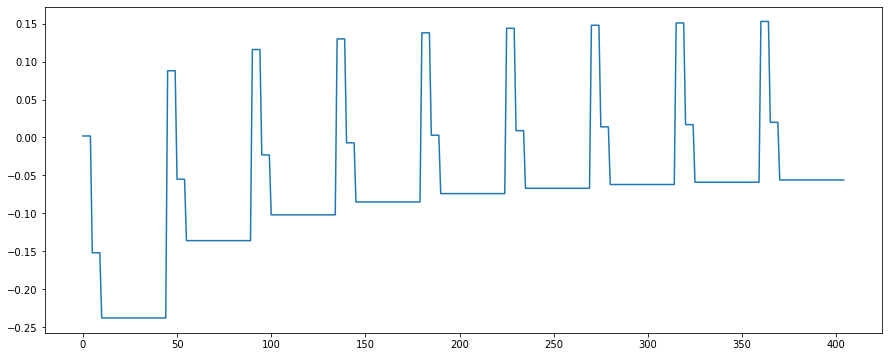

In [117]:
profit_r1 = profit_r1.flatten()

plt.figure(figsize=(15, 6))

plt.plot(profit_r1);

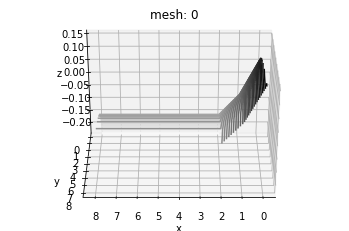

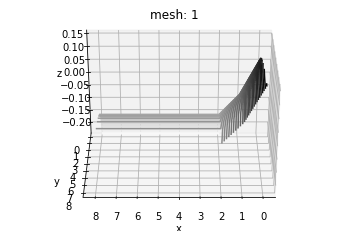

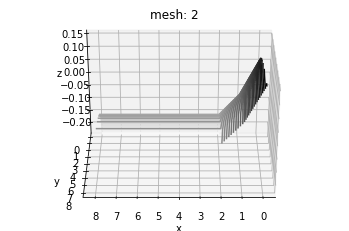

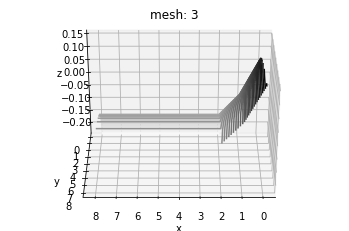

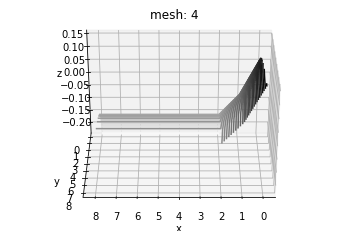

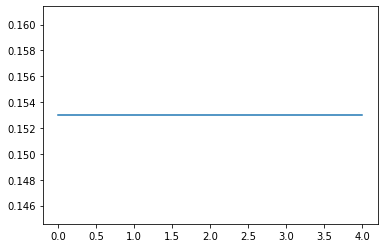

In [134]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

profit_r1 = pickle.load(open("profit_r1.p", "rb" ))
X=np.linspace(0, 8, 9)
Y=np.linspace(0, 8, 9)
Z = profit_r1[:,:,i]

for i in range(5):
  fig = plt.figure()
  ax = plt.axes(projection='3d')

  # ax.plot_surface(X=X, Y=Y, Z=Z, rstride=1, cstride=1,
  #                 cmap='viridis', edgecolor='none')
  ax.contour3D(X, Y, Z, 50, cmap='binary')
  ax.set_title(f'mesh: {i}');

  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z');

  # rotate the axes and update
  ax.view_init(30, 90) #55
  plt.show()

plt.plot(profit_r1[8, 0, :])

In [132]:
profit_r1.max()

0.153

In [ ]:
# mu = 30
# edge_max = 2
# flattened = 550
# max_gain = 30
# season_adj = 20
# delta = 4

In [25]:
### three ranges to test for profit ###

# range 1: [450, 700, 50]
# range 2: [1050, 1300, 50]
# renge 3: [1800+] (extrapolation, I suspect this is overfitting)

# mu = [5, 50, 5] 
# max_edge = [1.5, 6, .5]

# total epochs for scan: 405 (9*9)*(5) flattened from before 

profit_r2 = np.zeros((9, 9, 5))

m = 0
for mu in tqdm(range(5, 50, 5)):
  em = 0
  for edge_max in np.arange(1.5, 6, .5):
    f = 0
    for flattened in range(1050, 1300, 50):
      max_gain = 4+4*(flattened//120)
      season_adj = 10+5*((flattened%120)//15)
      delta = flattened%15

      with ThreadPoolExecutor(8) as ex:
        fun = ex.submit(betting_performance_for_target_year, Elo.copy(), max_gain, season_adj, delta, mu=mu, edge_max=edge_max)
        _, profit = fun.result()

      profit_r2[m, em, f] = profit
      f+=1
    em+=1
  m+=1

100%|██████████| 9/9 [38:56<00:00, 259.60s/it]


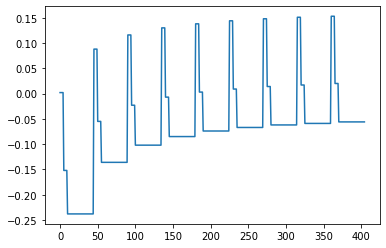

In [29]:
profit_r2 = profit_r2.flatten()
plt.plot(profit_r2)

In [14]:
### three ranges to test for profit ###

# range 1: [450, 700, 50]
# range 2: [1050, 1300, 50]
# renge 3: [1800+] (extrapolation, I suspect this is overfitting)

# mu = [5, 50, 5] 
# max_edge = [1.5, 6, .5]

# total epochs for scan: 405 (9*9)*(5) flattened from before 

profit_r3 = np.zeros((9, 9, 14))

m = 0
for mu in tqdm(range(5, 50, 5)):
  em = 0
  for edge_max in np.arange(1.5, 6, .5):
    f = 0
    for flattened in range(1800, 2500, 50):
      max_gain = 4+4*(flattened//120)
      season_adj = 10+5*((flattened%120)//15)
      delta = flattened%15

      with ThreadPoolExecutor(8) as ex:
        fun = ex.submit(betting_performance_for_target_year, Elo.copy(), max_gain, season_adj, delta, mu=mu, edge_max=edge_max)
        _, profit = fun.result()

      profit_r3[m, em, f] = profit
      f+=1
    em+=1
  m+=1

100%|██████████| 9/9 [1:42:36<00:00, 684.04s/it]


In [18]:
profit_r3
pickle.dump(profit_r3, open("profit_r3.p", "wb" ))

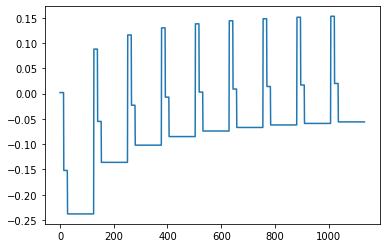

In [16]:
plt.plot(profit_r3.flatten())

In [31]:
profit_r3.flatten()[1008:1022]

array([0.153, 0.153, 0.153, 0.153, 0.153, 0.153, 0.153, 0.153, 0.153,
       0.153, 0.153, 0.153, 0.153, 0.153])

In [ ]:
### optimal ranges [1008, 1022], len: 15


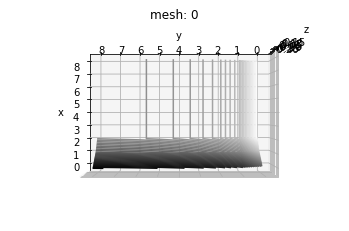

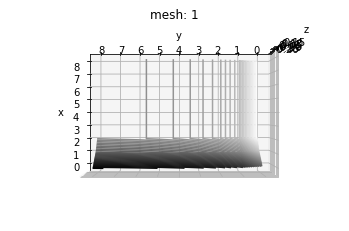

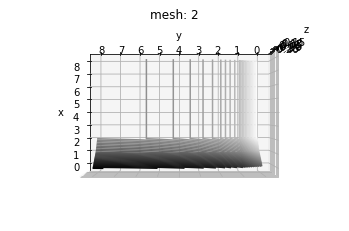

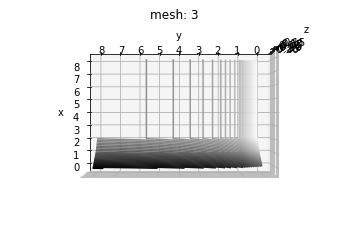

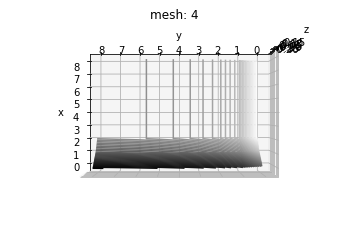

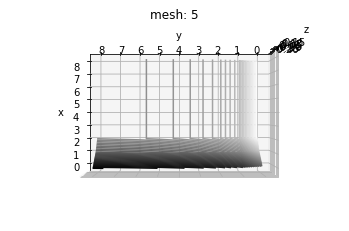

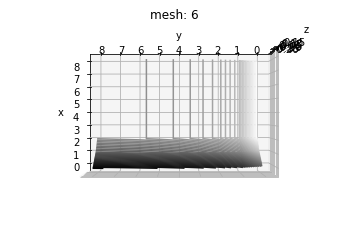

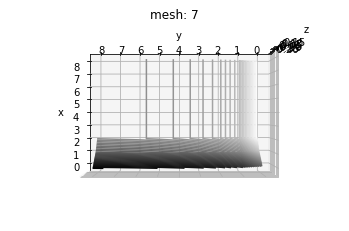

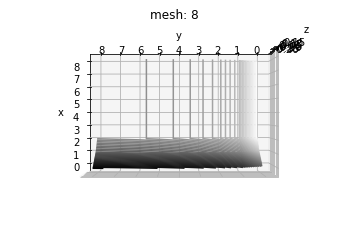

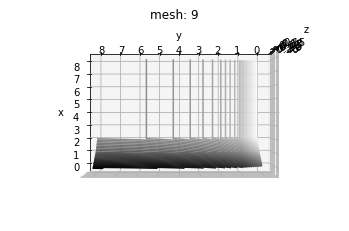

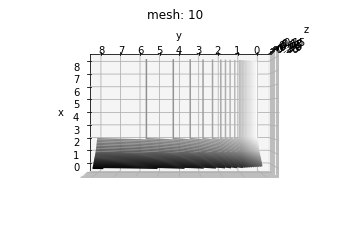

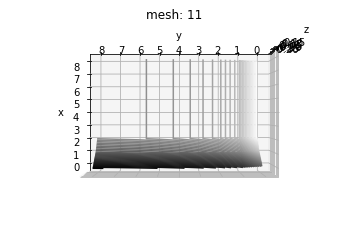

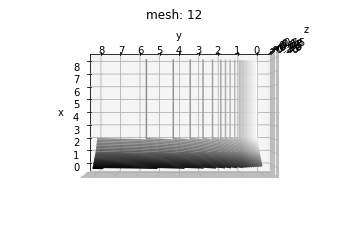

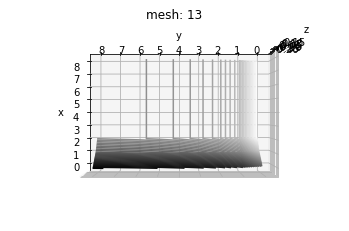

In [103]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


X=np.linspace(0, 8, 9)
Y=np.linspace(0, 8, 9)
for i in range(14):
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  Z = profit_r3[:,:,i]

  # ax.plot_surface(X=X, Y=Y, Z=Z, rstride=1, cstride=1,
  #                 cmap='viridis', edgecolor='none')
  ax.contour3D(X, Y, Z, 50, cmap='binary')
  ax.set_title(f'mesh: {i}');

  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z');

  # rotate the axes and update
  ax.view_init(90, 180) #55
  plt.show()

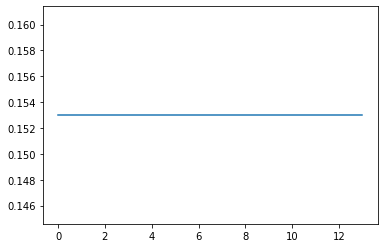

In [100]:
plt.plot(profit_r3[8, 0, :])

In [41]:
# mu = 30
# edge_max = 2
# flattened = 

(9, 9)